In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
np.random.seed(1337)
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(84).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(44).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(245).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/6.jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(238).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(196).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(108).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(310).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image (5).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(186).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(29).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(140).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(224).jpg

# Importing Libraries

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL
import pathlib
import cv2
from tensorflow.keras import layers
from sklearn.model_selection import KFold, StratifiedKFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob
import csv

In [3]:
print(tf.__version__)

2.4.1


# Preparing dataset

Link to the [Dataset being used](https://www.kaggle.com/sartajbhuvaji/brain-tumor-classification-mri)<br>
Reference Tutorial for general code: [Image Classification Tutorial](https://www.tensorflow.org/tutorials/images/classification)

In [4]:
#path_data = '../input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset'
path_test = '../input/brain-tumor-classification-mri/Testing'
path_data = '../input/brain-tumor-classification-mri/Training'


path_test = pathlib.Path(path_test)
path_data = pathlib.Path(path_data)
print(path_data)

image_count = len(list(path_data.glob('*/*.jpg')))
print(image_count)

../input/brain-tumor-classification-mri/Training
2870


#### Image of a brain with tumor

../input/brain-tumor-classification-mri/Training/glioma_tumor/gg (552).jpg


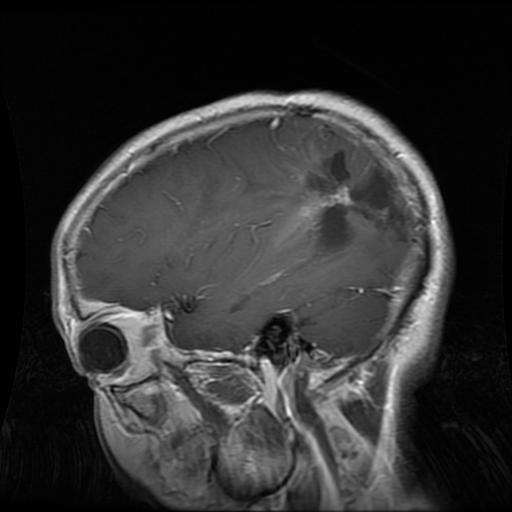

In [5]:
tumors = list(path_data.glob('glioma_tumor/*'))
print(tumors[1])
img1 = PIL.Image.open(str(tumors[0]))
img1

#### Image of a brain with no tumor

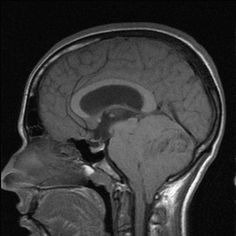

In [6]:
not_tumors = list(path_data.glob('no_tumor/*'))
img2 = PIL.Image.open(str(not_tumors[0]))
img2

In [7]:
img_opencv = cv2.imread(str(not_tumors[0]))
print(img_opencv.shape)
img_opencv1 = cv2.imread(str(tumors[0]))
print(img_opencv1.shape)

(236, 236, 3)
(512, 512, 3)


### Creating Testing Validation and Testing Sets

In [8]:
batch = 32
img_height = 180
img_width = 180

In [9]:
train = tf.keras.preprocessing.image_dataset_from_directory(
path_data,
validation_split = 0.2,
subset = 'training',
seed = 42,
image_size  =(img_height,img_width),
batch_size = batch)

Found 2870 files belonging to 4 classes.
Using 2296 files for training.


In [10]:
val = tf.keras.preprocessing.image_dataset_from_directory(
path_data,
validation_split = 0.2,
subset = 'validation',
seed = 42,
image_size = (img_height,img_width),
batch_size = batch)

Found 2870 files belonging to 4 classes.
Using 574 files for validation.


In [11]:
test = tf.keras.preprocessing.image_dataset_from_directory(
path_test,
seed = 42,
image_size = (img_height,img_width),
batch_size = batch)

Found 394 files belonging to 4 classes.


In [12]:
print(train.class_names)
print(val.class_names)
print(test.class_names)

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


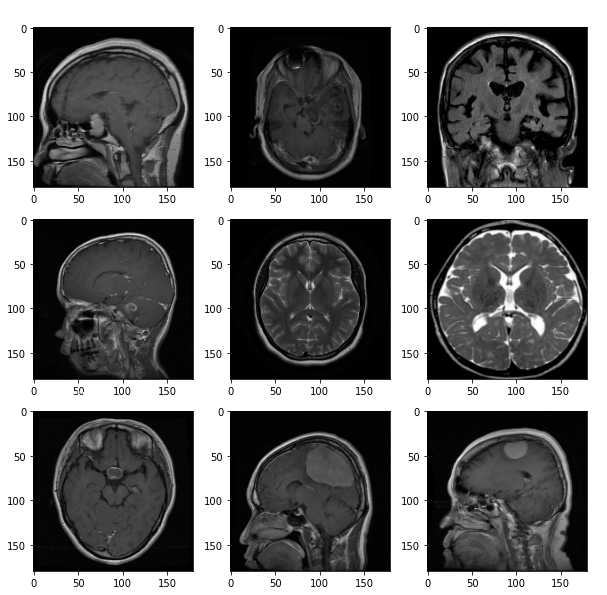

In [13]:
classes = train.class_names
plt.figure(figsize = (10,10))
for img,label in train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(img[i].numpy().astype("uint8"))
        plt.title(classes[label[i]],
                  fontdict = {'fontsize': '19',
                              'color': 'white'}
                 )
        

In [14]:
for image_batch, labels_batch in train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train = train.prefetch(buffer_size=AUTOTUNE)
val = val.prefetch(buffer_size=AUTOTUNE)
test = test.prefetch(buffer_size=AUTOTUNE)

# Helper Functions
<a id='helper'></a>

In [16]:
def prediction_label_comparison(model,test):
    #Retrieve a batch of images from the test set
    image_batch, label_batch = test.as_numpy_iterator().next()
    predictions = model.predict_on_batch(image_batch).flatten()

    # Apply a sigmoid since our model returns logits
    predictions = tf.nn.sigmoid(predictions).numpy()

    n = 0
    predict = []
    while n<=(predictions.shape[0]-4):
        pred = np.argmax(predictions[n:n+4]) #Returns the index of the largest element in the selected subarray
        n+=4
        predict.append(pred)
    predict = np.array(predict)

    #print('Predictions:\n',predictions)#.numpy())
    print('Labels:\n', label_batch)
    print('Predictions:\n',predict)
    '''
    print(predictions.shape)
    print(label_batch.shape)
    print(predict.shape)
    '''

    plt.figure(figsize=(10, 10))
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(image_batch[i].astype("uint8"))
      plt.title(classes[predict[i]],fontdict = {'fontsize': '14',
                                  'color': 'white'})
      plt.axis("off")

In [17]:
def test_tumor(list_test_path,model):
    # sunflower_url = 'https://'
    # sunflower_path = tf.keras.utils.get_file('name of file', origin=sunflower_url)
    for path_name in list_test_path:
        test_img_path = path_name


        test_image = tf.keras.preprocessing.image.load_img(
            test_img_path, target_size=(img_height, img_width)
        )
        test_array = tf.keras.preprocessing.image.img_to_array(test_image)
        test_array = tf.expand_dims(test_array, 0) # Create a batch

        predictions = model.predict(test_array)
        score = tf.nn.softmax(predictions[0])

        print(
            "This image most likely belongs to {} with a {:.2f} percent confidence."
            .format(classes[np.argmax(score)], 100 * np.max(score))
        )

In [18]:
def csv_builder(path_data,label_names):
    df = pd.DataFrame(columns = ['images','labels'])
    for name in label_names:
        BASE_DIR = str(path_data)+'/'
        #train_folder_glioma = BASE_DIR+'glioma_tumor/'
        train_folder_name = BASE_DIR+name+'/'

        #train_annotation = BASE_DIR+'annotated_train_data/'

        files_in_train = sorted(os.listdir(train_folder_name))
        #files_in_annotated = sorted(os.listdir(train_annotation))

        image_names =[i for i in files_in_train]

        
        for x in image_names:
            #df = df.append({'images':train_folder_name+str(x),'labels':name},ignore_index=True)
            df = df.append({'images':str(x),'labels':name},ignore_index=True)

        #df['images']=[train_folder_glioma+str(x) for x in image_names]
        #df['labels']=[train_annotation+str(x) for x in images]
        #pd.to_csv('files_path.csv', header=None)
    return df

In [19]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
conv_layer_32 = tf.keras.layers.Conv2D(32,(3,3),activation='relu')
conv_layer_64 = tf.keras.layers.Conv2D(64,3,activation='relu')
conv_layer_16 = tf.keras.layers.Conv2D(16,3,activation='relu')
max_pool = tf.keras.layers.MaxPooling2D()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

In [20]:
data_augmentation = tf.keras.Sequential(
  [
    normalization_layer,
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.1),
    #tf.keras.layers.experimental.preprocessing.RandomCrop(170,170)  
  ]
)

### Checking effects of the data augmentation

In [21]:
# IMG_SIZE = 180

# resize_and_rescale = tf.keras.Sequential([
#   tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
#   tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
# ])
# result = resize_and_rescale(img_opencv)
# _ = plt.imshow(result)

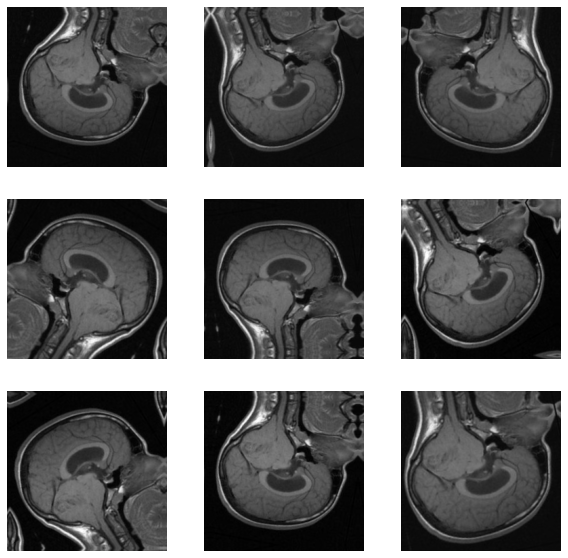

In [22]:
plt.figure(figsize=(10, 10))
img_array = tf.keras.preprocessing.image.img_to_array(img_opencv)
img_array = tf.expand_dims(img_array,0)
for i in range(9):
  augmented_image = data_augmentation(img_array)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

# Model Building

### References for model:<br>
Model 2: Obtained from a [Kaggle notebook](https://www.kaggle.com/chityeaung/brain-tumor-classification) by [chityeaung](https://www.kaggle.com/chityeaung)<br>
Model 1 and 3 taken from Tensorflow tutorials:<br>
[Image Classification Tutorial](https://www.tensorflow.org/tutorials/images/classification)<br>
[Transfer Learning Tutorial](https://www.tensorflow.org/tutorials/images/transfer_learning)

In [23]:
num_classes = 4

model = tf.keras.Sequential([
  normalization_layer,
  conv_layer_32,
  max_pool,
  conv_layer_32,
  max_pool,
  conv_layer_32,
  max_pool,
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [24]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])


In [25]:
history = model.fit(
    train,
    validation_data=val,
    epochs= 3,
    callbacks = callback,
    shuffle=False
)
eff_epochs = len(history.history['loss'])

Epoch 1/3
72/72 [==============================] - 17s 190ms/step - loss: 3.0162 - accuracy: 0.4889 - val_loss: 0.6197 - val_accuracy: 0.8014
Epoch 2/3
72/72 [==============================] - 6s 75ms/step - loss: 0.4490 - accuracy: 0.8274 - val_loss: 0.4417 - val_accuracy: 0.8589
Epoch 3/3
72/72 [==============================] - 6s 73ms/step - loss: 0.2123 - accuracy: 0.9223 - val_loss: 0.3919 - val_accuracy: 0.8763


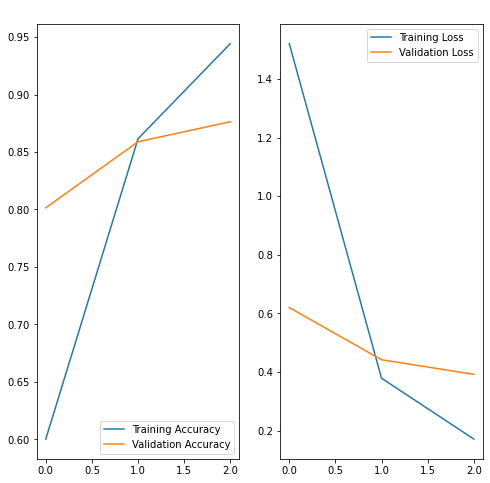

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = 10

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(eff_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy',fontdict = {'fontsize': '14',
                              'color': 'white'})

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss',fontdict = {'fontsize': '14',
                              'color': 'white'})
plt.show()

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        multiple                  0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 253472)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               32444544  
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 516       
Total params: 32,445,956
Trainable params: 32,445,956
Non-trainable params: 0
__________________________________________

In [28]:
results = model.evaluate(test)
print("test loss, test acc:", results)

13/13 [==============================] - 2s 50ms/step - loss: 2.3237 - accuracy: 0.6294
test loss, test acc: [2.3236961364746094, 0.6294416189193726]


In [29]:
list_of_paths = ['../input/brain-tumor-classification-mri/Testing/pituitary_tumor/image(20).jpg',
                '../input/brain-tumor-classification-mri/Testing/no_tumor/image(11).jpg',
                '../input/brain-tumor-classification-mri/Testing/meningioma_tumor/image(120).jpg',
                '../input/brain-tumor-classification-mri/Testing/glioma_tumor/image(16).jpg',
                '../input/brain-mri-images-for-brain-tumor-detection/yes/Y100.JPG']
test_tumor(list_of_paths,model)

This image most likely belongs to pituitary_tumor with a 67.55 percent confidence.
This image most likely belongs to no_tumor with a 89.52 percent confidence.
This image most likely belongs to meningioma_tumor with a 98.18 percent confidence.
This image most likely belongs to no_tumor with a 99.78 percent confidence.
This image most likely belongs to no_tumor with a 88.47 percent confidence.


# Second Model

Adding a data augmentation layer to add more images to the training data by simply modifying the existing images in ways such as flipping them or making similar random transformations to the training data.

In [30]:
num_classes = 4

model2 = tf.keras.Sequential([
  #data_augmentation,
  normalization_layer,
  #tf.keras.layers.Conv2D(32,3,activation='relu'),
  conv_layer_32,
  layers.MaxPooling2D(pool_size=(2,2)),
  conv_layer_32,
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Flatten(),
  layers.Dense(32, activation='relu'),
  layers.Dropout(0.25),
  layers.Dense(num_classes,activation='softmax')
])

In [31]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [32]:
epochs = 50
history = model2.fit(
  train,
  validation_data=val,
  epochs=epochs,
  callbacks = callback,
  shuffle=False
)

Epoch 1/50
72/72 [==============================] - 6s 74ms/step - loss: 1.1413 - accuracy: 0.5100 - val_loss: 0.6172 - val_accuracy: 0.7770
Epoch 2/50
72/72 [==============================] - 6s 73ms/step - loss: 0.5769 - accuracy: 0.7667 - val_loss: 0.5221 - val_accuracy: 0.7474
Epoch 3/50
72/72 [==============================] - 6s 71ms/step - loss: 0.4084 - accuracy: 0.8491 - val_loss: 0.4125 - val_accuracy: 0.8484
Epoch 4/50
72/72 [==============================] - 6s 73ms/step - loss: 0.2689 - accuracy: 0.9040 - val_loss: 0.3629 - val_accuracy: 0.8763
Epoch 5/50
72/72 [==============================] - 6s 71ms/step - loss: 0.2110 - accuracy: 0.9268 - val_loss: 0.3283 - val_accuracy: 0.8937
Epoch 6/50
72/72 [==============================] - 6s 81ms/step - loss: 0.1652 - accuracy: 0.9480 - val_loss: 0.3616 - val_accuracy: 0.8868
Epoch 7/50
72/72 [==============================] - 6s 72ms/step - loss: 0.1162 - accuracy: 0.9645 - val_loss: 0.3405 - val_accuracy: 0.8972
Epoch 8/50
72

In [33]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        multiple                  0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 89, 89, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 44, 44, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 61952)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1982496   
_________________________________________________________________
dropout (Dropout)            (None, 32)               

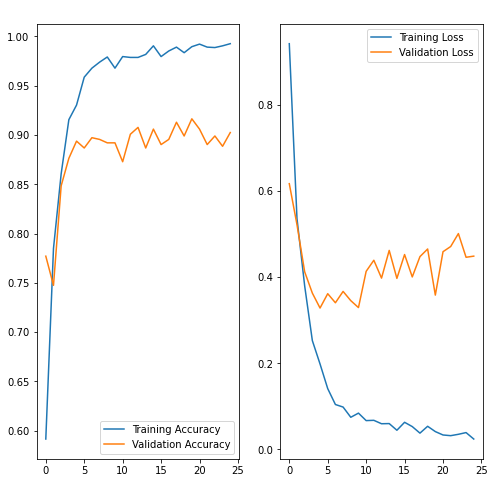

In [34]:
eff_epochs = len(history.history['loss'])
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = 10

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(eff_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy',fontdict = {'fontsize': '14',
                              'color': 'white'})

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss',fontdict = {'fontsize': '14',
                              'color': 'white'})
plt.show()

In [35]:
results = model2.evaluate(test)
print("test loss, test acc:", results)

13/13 [==============================] - 1s 21ms/step - loss: 3.4845 - accuracy: 0.7081
test loss, test acc: [3.484484910964966, 0.7081218361854553]


In [36]:
list_of_paths = ['../input/brain-tumor-classification-mri/Testing/pituitary_tumor/image(20).jpg',
                '../input/brain-tumor-classification-mri/Testing/no_tumor/image(11).jpg',
                '../input/brain-tumor-classification-mri/Testing/meningioma_tumor/image(120).jpg',
                '../input/brain-tumor-classification-mri/Testing/glioma_tumor/image(16).jpg',
                '../input/brain-mri-images-for-brain-tumor-detection/yes/Y100.JPG']
test_tumor(list_of_paths,model2)

This image most likely belongs to pituitary_tumor with a 46.33 percent confidence.
This image most likely belongs to no_tumor with a 46.61 percent confidence.
This image most likely belongs to meningioma_tumor with a 47.54 percent confidence.
This image most likely belongs to no_tumor with a 47.54 percent confidence.
This image most likely belongs to no_tumor with a 46.80 percent confidence.


## Third Model
### Using a pretrained model: MobileNetV2

In [37]:
# Create the base model from the pre-trained model MobileNet V2
image_size = (img_width,img_height)
IMG_SHAPE = image_size + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [38]:
image_batch, label_batch = next(iter(train))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 6, 6, 1280)


In [39]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 90, 90, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 90, 90, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 90, 90, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [40]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [41]:
prediction_layer = tf.keras.layers.Dense(4)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 4)


In [42]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [43]:
help(preprocess_input)

Help on function preprocess_input in module tensorflow.python.keras.applications.mobilenet_v2:

preprocess_input(x, data_format=None)
    Preprocesses a tensor or Numpy array encoding a batch of images.
    
    Usage example with `applications.MobileNet`:
    
    ```python
    i = tf.keras.layers.Input([None, None, 3], dtype = tf.uint8)
    x = tf.cast(i, tf.float32)
    x = tf.keras.applications.mobilenet.preprocess_input(x)
    core = tf.keras.applications.MobileNet()
    x = core(x)
    model = tf.keras.Model(inputs=[i], outputs=[x])
    
    image = tf.image.decode_png(tf.io.read_file('file.png'))
    result = model(image)
    ```
    
    Arguments:
      x: A floating point `numpy.array` or a `tf.Tensor`, 3D or 4D with 3 color
        channels, with values in the range [0, 255].
        The preprocessed data are written over the input data
        if the data types are compatible. To avoid this
        behaviour, `numpy.copy(x)` can be used.
      data_format: Optional data for

In [44]:
inputs = tf.keras.Input(shape=(180, 180, 3))
#x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1280,activation='relu')(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [45]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [46]:
len(model.trainable_variables)

4

In [47]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

18/18 [==============================] - 3s 47ms/step - loss: 1.4439 - accuracy: 0.3389
initial loss: 1.45
initial accuracy: 0.35


In [48]:
history_base = model.fit(train,
                         epochs=initial_epochs,
                         validation_data=val,
                         shuffle=False
                        )

Epoch 1/10
72/72 [==============================] - 8s 79ms/step - loss: 0.7218 - accuracy: 0.7139 - val_loss: 0.5039 - val_accuracy: 0.8066
Epoch 2/10
72/72 [==============================] - 6s 77ms/step - loss: 0.4193 - accuracy: 0.8380 - val_loss: 0.4352 - val_accuracy: 0.8293
Epoch 3/10
72/72 [==============================] - 6s 78ms/step - loss: 0.3385 - accuracy: 0.8706 - val_loss: 0.3806 - val_accuracy: 0.8624
Epoch 4/10
72/72 [==============================] - 7s 84ms/step - loss: 0.2864 - accuracy: 0.8959 - val_loss: 0.3622 - val_accuracy: 0.8606
Epoch 5/10
72/72 [==============================] - 6s 79ms/step - loss: 0.2593 - accuracy: 0.9064 - val_loss: 0.4460 - val_accuracy: 0.8415
Epoch 6/10
72/72 [==============================] - 6s 80ms/step - loss: 0.2354 - accuracy: 0.9177 - val_loss: 0.3377 - val_accuracy: 0.8728
Epoch 7/10
72/72 [==============================] - 6s 77ms/step - loss: 0.2252 - accuracy: 0.9190 - val_loss: 0.3615 - val_accuracy: 0.8624
Epoch 8/10
72

In [49]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 180, 180, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 180, 180, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1280)              0     

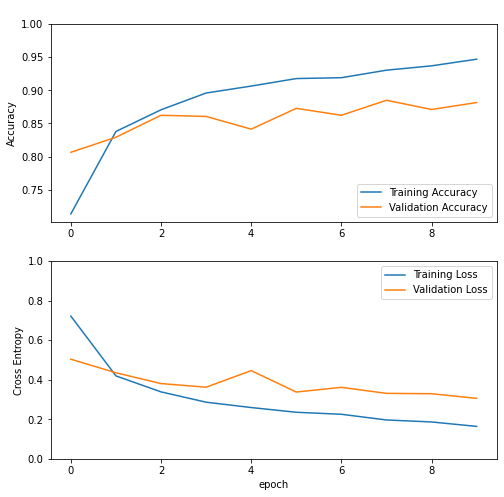

In [50]:
acc = history_base.history['accuracy']
val_acc = history_base.history['val_accuracy']

loss = history_base.history['loss']
val_loss = history_base.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy',fontdict = {'fontsize': '14',
                              'color': 'white'})

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')


plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss',fontdict = {'fontsize': '14',
                              'color': 'white'})
plt.xlabel('epoch')
plt.show()

In [51]:
list_of_paths = ['../input/brain-tumor-classification-mri/Testing/pituitary_tumor/image(20).jpg',
                '../input/brain-tumor-classification-mri/Testing/no_tumor/image(11).jpg',
                '../input/brain-tumor-classification-mri/Testing/meningioma_tumor/image(120).jpg',
                '../input/brain-tumor-classification-mri/Testing/glioma_tumor/image(16).jpg',
                '../input/brain-mri-images-for-brain-tumor-detection/yes/Y100.JPG',
                '../input/brain-mri-images-for-brain-tumor-detection/no/14 no.jpg']
test_tumor(list_of_paths,model)

This image most likely belongs to pituitary_tumor with a 87.96 percent confidence.
This image most likely belongs to no_tumor with a 94.61 percent confidence.
This image most likely belongs to meningioma_tumor with a 99.44 percent confidence.
This image most likely belongs to meningioma_tumor with a 61.29 percent confidence.
This image most likely belongs to no_tumor with a 97.67 percent confidence.
This image most likely belongs to no_tumor with a 98.13 percent confidence.


In [52]:
result = model.evaluate(test)
print(result)

13/13 [==============================] - 1s 38ms/step - loss: 1.4008 - accuracy: 0.7056
[1.4008294343948364, 0.7055837512016296]


## Fine Tuning the model

In [53]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

#Attempting to fine tune more layers
more_layer = 50



#Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


Changing the number of trainable layers doesn't affect the test accuracy too much. 

In [54]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [55]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 180, 180, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 180, 180, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1280)              0     

In [56]:
len(model.trainable_variables)

58

In [57]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train,
                         epochs=total_epochs,
                         initial_epoch=history_base.epoch[-1],
                         validation_data=val)

Epoch 10/20
72/72 [==============================] - 11s 98ms/step - loss: 0.1791 - accuracy: 0.9288 - val_loss: 0.3164 - val_accuracy: 0.8902
Epoch 11/20
72/72 [==============================] - 6s 83ms/step - loss: 0.1160 - accuracy: 0.9707 - val_loss: 0.2816 - val_accuracy: 0.8937
Epoch 12/20
72/72 [==============================] - 6s 83ms/step - loss: 0.0932 - accuracy: 0.9759 - val_loss: 0.2896 - val_accuracy: 0.8955
Epoch 13/20
72/72 [==============================] - 7s 84ms/step - loss: 0.0801 - accuracy: 0.9761 - val_loss: 0.2871 - val_accuracy: 0.8937
Epoch 14/20
72/72 [==============================] - 7s 91ms/step - loss: 0.0707 - accuracy: 0.9796 - val_loss: 0.2617 - val_accuracy: 0.9077
Epoch 15/20
72/72 [==============================] - 7s 84ms/step - loss: 0.0541 - accuracy: 0.9841 - val_loss: 0.2878 - val_accuracy: 0.8990
Epoch 16/20
72/72 [==============================] - 6s 83ms/step - loss: 0.0502 - accuracy: 0.9877 - val_loss: 0.2606 - val_accuracy: 0.9111
Epoch

In [58]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

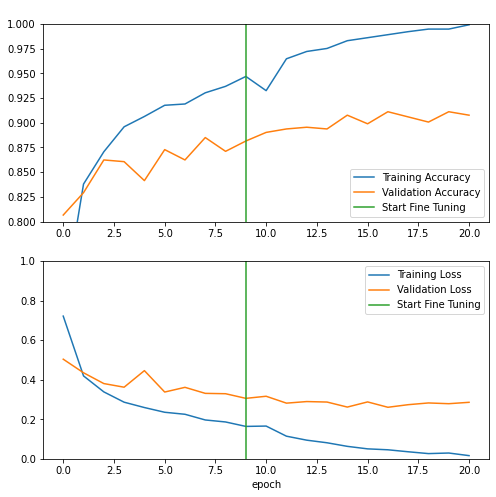

In [59]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy',fontdict = {'fontsize': '14',
                              'color': 'white'})

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss',fontdict = {'fontsize': '14',
                              'color': 'white'})
plt.xlabel('epoch')
plt.show()

In [60]:
loss, accuracy = model.evaluate(test)
print('Test accuracy :', accuracy)

13/13 [==============================] - 1s 34ms/step - loss: 2.2742 - accuracy: 0.7284
Test accuracy : 0.7284263968467712


In [61]:
list_of_paths = ['../input/brain-tumor-classification-mri/Testing/pituitary_tumor/image(20).jpg',
                '../input/brain-tumor-classification-mri/Testing/no_tumor/image(11).jpg',
                '../input/brain-tumor-classification-mri/Testing/meningioma_tumor/image(120).jpg',
                '../input/brain-tumor-classification-mri/Testing/glioma_tumor/image(16).jpg',
                '../input/brain-mri-images-for-brain-tumor-detection/yes/Y100.JPG']
test_tumor(list_of_paths,model)

This image most likely belongs to pituitary_tumor with a 99.54 percent confidence.
This image most likely belongs to no_tumor with a 99.82 percent confidence.
This image most likely belongs to meningioma_tumor with a 99.99 percent confidence.
This image most likely belongs to meningioma_tumor with a 64.93 percent confidence.
This image most likely belongs to no_tumor with a 99.43 percent confidence.


Labels:
 [2 1 1 1 0 1 1 2 0 2 0 3 0 0 3 2 2 0 1 0 3 3 0 2 1 1 1 0 0 2 1 0]
Predictions:
 [2 1 1 1 1 1 1 2 1 2 1 3 1 2 3 2 2 1 1 2 2 2 1 2 1 3 1 1 2 2 1 2]


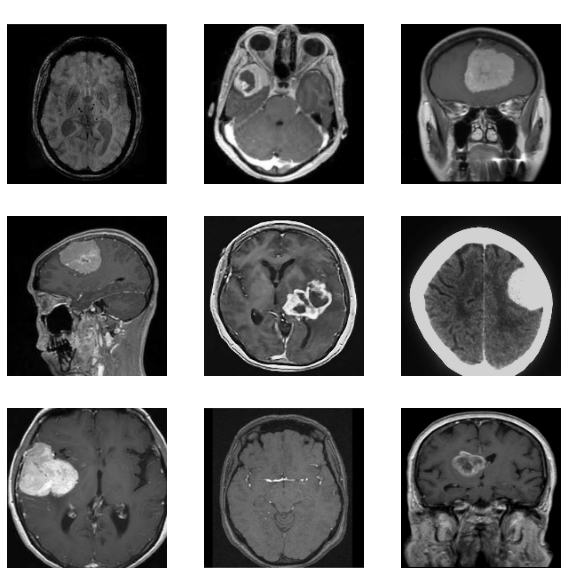

In [62]:
prediction_label_comparison(model,test)

## Using k-fold cross validation

#### Reference article for the k-fold cross validation: [Link](https://medium.com/the-owl/k-fold-cross-validation-in-keras-3ec4a3a00538)

## Building a .csv file for the images along with their labels: [Reference](https://datascience.stackexchange.com/questions/49094/how-to-transform-a-folder-of-images-into-csv-file)

In [63]:
path_data

PosixPath('../input/brain-tumor-classification-mri/Training')

In [64]:
label_names = os.listdir(path_data)
label_names

['no_tumor', 'pituitary_tumor', 'meningioma_tumor', 'glioma_tumor']

Function csv_builder() has been defined in the [helper functions](#helper)

In [65]:
final_csv = csv_builder(path_data,label_names)
final_csv

,images,labels
0,1.jpg,no_tumor
1,2.jpg,no_tumor
2,3.jpg,no_tumor
3,4.jpg,no_tumor
4,5.jpg,no_tumor
...,...,...
2865,gg (95).jpg,glioma_tumor
2866,gg (96).jpg,glioma_tumor
2867,gg (97).jpg,glioma_tumor
2868,gg (98).jpg,glioma_tumor


In [66]:
final_csv

,images,labels
0,1.jpg,no_tumor
1,2.jpg,no_tumor
2,3.jpg,no_tumor
3,4.jpg,no_tumor
4,5.jpg,no_tumor
...,...,...
2865,gg (95).jpg,glioma_tumor
2866,gg (96).jpg,glioma_tumor
2867,gg (97).jpg,glioma_tumor
2868,gg (98).jpg,glioma_tumor


In [67]:
final_csv.to_csv('files_path.csv', header=None)

In [68]:
path_of_csv = './files_path.csv'

### Now this csv file can be used to create a kfold split in the training data

In [69]:
n_splits = 5
Y = final_csv[['labels']]
kf = KFold(n_splits = 5)
skf = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True) 

In [70]:
n = len(Y)
print(n)


2870


In [71]:
idg = ImageDataGenerator(width_shift_range=0.1,
                         height_shift_range=0.1,
                         zoom_range=0.3,
                         fill_mode='nearest',
                         horizontal_flip = True,
                         rescale=1./255)

In [72]:
# for train_index, val_index in kf.split(np.zeros(n),Y):
# 	training_data = final_csv.iloc[train_index]
# 	validation_data = final_csv.iloc[val_index]

# train_data_generator = idg.flow_from_dataframe(training_data, directory = path_data,
# 					       x_col = "images", y_col = "labels",
# 					       class_mode = "categorical", shuffle = True,subset='training')
# valid_data_generator  = idg.flow_from_dataframe(validation_data, directory = path_data,
# 						x_col = "images", y_col = "labels",
# 						class_mode = "categorical", shuffle = True,subset='validation')	

In [73]:
help(idg)

Help on ImageDataGenerator in module tensorflow.python.keras.preprocessing.image object:

class ImageDataGenerator(keras_preprocessing.image.image_data_generator.ImageDataGenerator)
 |  ImageDataGenerator(featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False, samplewise_std_normalization=False, zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0, height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0, channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False, vertical_flip=False, rescale=None, preprocessing_function=None, data_format=None, validation_split=0.0, dtype=None)
 |  
 |  Generate batches of tensor image data with real-time data augmentation.
 |  
 |   The data will be looped over (in batches).
 |  
 |  Arguments:
 |      featurewise_center: Boolean.
 |          Set input mean to 0 over the dataset, feature-wise.
 |      samplewise_center: Boolean. Set each sample mean to 

In [74]:
help(idg.flow_from_dataframe)

Help on method flow_from_dataframe in module tensorflow.python.keras.preprocessing.image:

flow_from_dataframe(dataframe, directory=None, x_col='filename', y_col='class', weight_col=None, target_size=(256, 256), color_mode='rgb', classes=None, class_mode='categorical', batch_size=32, shuffle=True, seed=None, save_to_dir=None, save_prefix='', save_format='png', subset=None, interpolation='nearest', validate_filenames=True, **kwargs) method of tensorflow.python.keras.preprocessing.image.ImageDataGenerator instance
    Takes the dataframe and the path to a directory + generates batches.
    
     The generated batches contain augmented/normalized data.
    
    **A simple tutorial can be found **[here](
                                http://bit.ly/keras_flow_from_dataframe).
    
    Arguments:
        dataframe: Pandas dataframe containing the filepaths relative to
          `directory` (or absolute paths if `directory` is None) of the images
          in a string column. It should incl

In [75]:
# # CREATE NEW MODEL
# model = model
# # COMPILE NEW MODEL
# model.compile(loss='categorical_crossentropy',
# 	      optimizer=opt,
# 	      metrics=['accuracy'])

# # There can be other callbacks, but just showing one because it involves the model name
# # This saves the best model
# # FIT THE MODEL
# history = model.fit(train_data_generator,
# 		    epochs=num_epochs,
# 		    callbacks=callbacks_list,
# 		    validation_data=valid_data_generator)
# #PLOT HISTORY
# #		:
# #		:

# # LOAD BEST MODEL to evaluate the performance of the model


# results = model.evaluate(valid_data_generator)
# results = dict(zip(model.metrics_names,results))

# VALIDATION_ACCURACY.append(results['accuracy'])
# VALIDATION_LOSS.append(results['loss'])

# tf.keras.backend.clear_session()

# fold_var += 1
